# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Tutorial 08 - Homography, Alignment & Panoramas
---

## <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Matching Local Features](#-Matching-Local-Features)
* [Parametric Transformations](#-Parametric-Transformations)
* [Computing Parametric Transformations](#-Computing-Parametric-Transformations)
    * [Affine](#Computing-Affine-Transformation)
    * [Projective](#Computing-Projective-Transformation)
* [RANSAC](#-RANSAC)
* [Panorama](#-Panorama)
    * [Warping](#-Warp---What-we-need-to-solve?)
    * [Image Blending (Feathering)](#-Image-Blending)
* [Kornia & Transformations in Deep Learning](#--Transformations-in-Deep-Learning)
* [Recommended Videos](#-Recommended-Videos)
* [Credits](#-Credits)

The largest panorama in the world (2014): Mont Blanc
 
<a href="https://youtu.be/Dwyx0h9h8zg ">In2WHITE Video</a>
 
<a href="http://www.in2white.com/">In2WHITE Full Image</a>


Homographic usage examples:

http://blog.flickr.net/en/2010/01/27/a-look-into-the-past/ 

https://www.instagram.com/albumplusart/

In [99]:
%%html
<iframe src="http://www.in2white.com/" width="700" height="600"></iframe>

In [100]:
# imports for the tutorial
import numpy as np,sys
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from scipy import signal
%matplotlib inline

In [101]:
# plot images function
def plot_images(image_list, title_list, subplot_shape=(1,1), axis='off', fontsize=30, figsize=(4,4), cmap=['gray']):
    plt.figure(figsize=figsize)
    for ii, im in enumerate(image_list):
        c_title = title_list[ii]
        if len(cmap) > 1:
            c_cmap = cmap[ii]
        else:
            c_cmap = cmap[0]
        plt.subplot(subplot_shape[0], subplot_shape[1],ii+1)
        plt.imshow(im, cmap=c_cmap)
        plt.title(c_title, fontsize=fontsize)
        plt.axis(axis)

### <img src="https://img.icons8.com/cotton/64/000000/fingerprint-scan.png" style="height:50px;display:inline"> Matching Local Features
--- 

#### Feature matching
---
* We know how to detect and describe good points

* Next question: How to match them?

<img src="./assets/tut_8_features1.png" width="600">

#### Typical feature matching results
---
* Some matches are correct
* Some matches are incorrect

<img src="./assets/tut_8_features2.png" width="600">

* Solution:   search for a set of geometrically consistent matches

###  <img src="https://img.icons8.com/ultraviolet/80/000000/transition-both-directions.png" style="height:50px;display:inline"> Parametric Transformations
---

#### Image Alignment
---
Given a set of matches, what parametric model describes a geometrically consistent transformation?

<img src="./assets/tut_8_alignment1.png" width="600">


#### Basic 2D Transformations
---
<img src="./assets/tut_8_alignment4.png" width="600">




<img src="./assets/tut_8_alignment3.png" width="600">

### Parametric (Global) Warping
---
Examples of parametric warps:

In [102]:
im = cv2.imread('./assets/tut_8_exm.jpg')
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
rows,cols,d = im.shape
print(im.shape)

# Translation:
tx,ty = [10,20]
h_T = np.float32([[1,0,tx],[0,1,ty],[0,0,1]])

# Rotation
theta = np.deg2rad(20)
h_R = np.float32([[np.cos(theta),-np.sin(theta),0],[np.sin(theta),np.cos(theta),0],[0,0,1]])

# Affine
h_AFF = np.array([[  1.26666667,-0.5,-60],[ -0.33333333,1,66.66666667],[0,0,1]])

H = [h_T,h_R,h_AFF]

img = [im]
for h in H:
    img.append(cv2.warpPerspective(im, h,(cols,rows)))
Titles = ['Original','Translation','Rotation','Affine']


# Perspective
pts1 = np.float32([[100,77],[320,105],[100,150],[385,170]])
pts2 = np.float32([[0,0],[300,0],[0,100],[300,50]])
M = cv2.getPerspectiveTransform(pts1,pts2)
im_perspective = cv2.warpPerspective(im,M,(400,300))

# Cylindrical (non linear)
def cylindricalWarp(img, K):
    """This function returns the cylindrical warp for a given image and intrinsics matrix K"""
    h_,w_ = img.shape[:2]
    # pixel coordinates
    y_i, x_i = np.indices((h_,w_))
    X = np.stack([x_i,y_i,np.ones_like(x_i)],axis=-1).reshape(h_*w_,3) # to homog
    Kinv = np.linalg.inv(K) 
    X = Kinv.dot(X.T).T # normalized coords
    # calculate cylindrical coords (sin\theta, h, cos\theta)
    A = np.stack([np.sin(X[:,0]),X[:,1],np.cos(X[:,0])],axis=-1).reshape(w_*h_,3)
    B = K.dot(A.T).T # project back to image-pixels plane
    # back from homog coords
    B = B[:,:-1] / B[:,[-1]]
    # make sure warp coords only within image bounds
    B[(B[:,0] < 0) | (B[:,0] >= w_) | (B[:,1] < 0) | (B[:,1] >= h_)] = -1
    B = B.reshape(h_,w_,-1)
    
    img_rgba = cv2.cvtColor(img,cv2.COLOR_RGB2RGBA) #BGR2BGRA for transparent borders...
    # warp the image according to cylindrical coords
    return cv2.remap(img_rgba, B[:,:,0].astype(np.float32), B[:,:,1].astype(np.float32),
                     cv2.INTER_AREA, borderMode=cv2.BORDER_TRANSPARENT)
# Camera parameters:
K = np.array([[200,0,cols/2],[0,400,rows/2],[0,0,1]]) # mock intrinsics
img_cyl = cylindricalWarp(im, K)

(362, 484, 3)


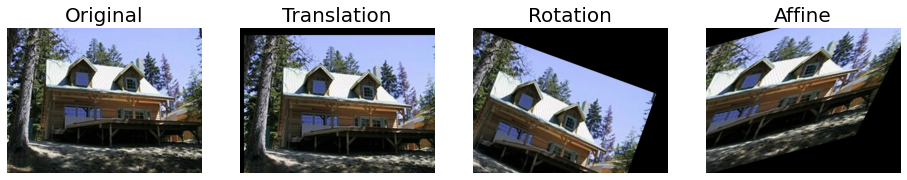

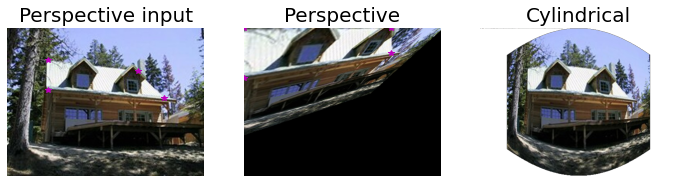

In [103]:
plot_images(img,Titles,(1,4),figsize=(16,4),fontsize=20)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(im),plt.title('Perspective input',fontsize=20)
plt.plot(pts1[:,0],pts1[:,1],'m*')
plt.axis('off')
plt.subplot(132),plt.imshow(im_perspective),plt.title('Perspective',fontsize=20)
plt.plot(pts2[:,0],pts2[:,1],'m*')
plt.axis('off')
plt.subplot(133),plt.imshow(img_cyl)
plt.title('Cylindrical',fontsize=20)
_ = plt.axis('off')

* <a href="https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html">Code source</a> - OpenCV

* <a href="https://www.morethantechnical.com/2018/10/30/cylindrical-image-warping-for-panorama-stitching/ ">Cylinder code source</a> - More Than Technical

* <a href="https://en.wikipedia.org/wiki/Cylindrical_coordinate_system ">Cylinder coordinates</a>



### <img src="https://img.icons8.com/material/48/000000/change.png" style="height:50px;display:inline"> Basic 2D Transformations
---
<img src="./assets/tut_8_alignment5.png" width="600">


#### When do we get Homography?
Homography maps between:
* points on a plane in the world and their positions in an image
* points in two different images of the **same** plane
* two images of a 3D object where the camera has rotated but not translated

For far away objects:
* works fine for small viewpoint changes

### <img src="https://img.icons8.com/office/80/000000/abacus.png" style="height:50px;display:inline"> Computing Parametric Transformations
---
* [Affine](#Computing-Affine-Transformation)
* [Projective](#Computing-Projective-Transformation)

#### Computing Affine Transformation
---
* Assuming we know correspondences, how do we get transformation?

$$  \begin{bmatrix} x_i' \\ y_i'  \\ 1  \end{bmatrix}= \begin{bmatrix} h_1 & h_2 & h_3\\ h_4 & h_5 & h_6 \\ 0 & 0 & 1 \end{bmatrix} 
\begin{bmatrix} x_i \\ y_i  \\ 1 \end{bmatrix}$$

$$ \begin{bmatrix} \dots \\ x_i' \\ y_i'  \\ \dots \end{bmatrix}= \begin{bmatrix} &&\dots\\ x_i & y_i & 1 & 0 & 0 & 0 \\ 0&0&0&x_i&y_i&1  \\ &&\dots \end{bmatrix} 
\begin{bmatrix} h_1\\h_2\\h_3\\ h_4 \\ h_5 \\ h_6 \\ \end{bmatrix} $$

$$b = Ah$$

* Solve with Least-squares
    $||Ah-b||^2$
    $$h = (A^TA)^{-1}A^Tb$$
In Python:

`A_inv = pinv(A)`

`h = np.linalg.pinv(A)@b`
* How many matches (correspondence pairs) do we need to solve?
* Once we have solved for the parameters, how do we compute the coordinates of the corresponding point for any pixel $(x_{new},y_{new})$?


$$ H = \begin{bmatrix} h_1 & h_2 & h_3\\ h_4 & h_5 & h_6 \\ 0 & 0 & 1 \end{bmatrix} $$

$$x'_{new} = Hx_{new}$$

#### Computing Projective Transformation
---
* Recall working with homogenous coordinates

$$  \begin{bmatrix} u_i \\ v_i  \\ w_i  \end{bmatrix}= \begin{bmatrix} h_1 & h_2 & h_3\\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}
\begin{bmatrix} x_i \\ y_i  \\ 1  \end{bmatrix} $$

$$ x_i' = u_i/w_i$$ 

$$y_i' = v_i/w_i$$



* We get the following non-linear equation:

$$ x_i' = \frac{h_1x_i + h_2 y_i + h_3}{h_7x_i+h_8y_i+h_9}$$ 

$$y_i' = \frac{h_4x_i + h_5 y_i + h_6}{h_7x_i+h_8y_i+h_9}$$



* We can re-arrange the equation

$$ \begin{bmatrix} &&&&&\dots\\ x_i & y_i & 1 & 0 & 0 & 0 & -x_ix_i'&-y_ix_i'& -x_i' \\ 0&0&0&x_i&y_i&1 & -x_iy_i'&-y_iy_i'& -y_i' \\ &&&&&\dots \end{bmatrix} 
\begin{bmatrix} h_1\\h_2\\h_3\\ h_4 \\ h_5 \\ h_6 \\ h_7\\h_8\\h_9\\ \end{bmatrix} = \begin{bmatrix} \dots \\ 0 \\ 0  \\ \dots \end{bmatrix}$$



* We want to find a vector $h$ satisfying

$$Ah=0$$

where A is full rank. We are obviously not interested in the trivial solution $h=0$ hence we add the constraint
$$||h||=1$$

* Thus, we get the homogeneous Least square equation:

$$ arg\min_h{||Ah||_2^2} \text{,   } s.t ||h||_2^2=1 $$


Compute Projective transformation using SVD:
$$arg \min_h{||Ah||_2^2} \text{,   } s.t ||h||_2^2=1 $$

* Let decompose $A$ using SVD: $ A = UDV^T $, where $U$ and $V$ are orthonomal matrix, and $D$ is a diagonal matrix.
    * Need a reminder on SVD? <a href="https://nbviewer.jupyter.org/github/taldatech/cs236756-intro-to-ml/blob/master/cs236756_tutorial_03_linear_algebra.ipynb"> Click Here </a>

* From orthonormality of $U$ and $V$:

$$ ||UDV^Th||=||DV^Th||$$
$$ ||V^Th||=||h|| $$

Hence, we get the following minimization problem:

$$ arg \min_h||DV^Th|| \text{ s.t. } ||V^Th||=1 $$


* Subsitute $y=V^Th$:
$$ arg \min_h||Dy|| \text{ s.t. } ||y||=1 $$

* $D$ is a diagonal matrix with decreasing values. Then, it is clear that $y=[0,0,\dots,1]^T$.

* Therefore, choosing $h$ to be the last column in $V$ will minimize the equation.

In Python:

`(U,D,Vh) = np.linalg.svd(A,False)`

`h = Vh.T[:,-1]`

#### Some more options to find $h$:


* Lagrange multipliers - <a href="http://cmp.felk.cvut.cz/cmp/courses/XE33PVR/WS20072008/Lectures/Supporting/constrained_lsq.pdf"> Least–squares Solution of Homogeneous Equations </a>

* Using EVD (eigenvalue decomposition) on $A^TA$.
* If we know our transformation is nearly Affine we can get an approximate solution using linear least squares


## <img src="https://img.icons8.com/external-photo3ideastudio-lineal-color-photo3ideastudio/344/external-exam-online-learning-photo3ideastudio-lineal-color-photo3ideastudio-1.png" style="height:50px;display:inline"> Spring 2020 Q1

### Q1.A write the homography H (3x3), that maps image-1 into image-2 in the following cases:
* Image-2 is a translated image 1 by 100 pixels to the left
* Image-2 is a 3x zoom of image 1, so the index (0,0) stay in place

### <img src="https://img.icons8.com/external-photo3ideastudio-lineal-color-photo3ideastudio/344/external-exam-online-learning-photo3ideastudio-lineal-color-photo3ideastudio-1.png" style="height:50px;display:inline"> Answer 1.A: 
* Image-2 is a translated image 1 by 10 pixels to the left:

we know that translation matrix looks like $$\begin{bmatrix} 1 & 0 & t_x\\ 0 & 1 & t_y \\ 0 & 0 & 1 \end{bmatrix}$$

and the translation is into the left only, means $$x_2 = x_1 -100 \\ y_2 = y_1$$

the matrix represent the translation  would be:
$$\begin{bmatrix} 1 & 0 & -100\\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}$$

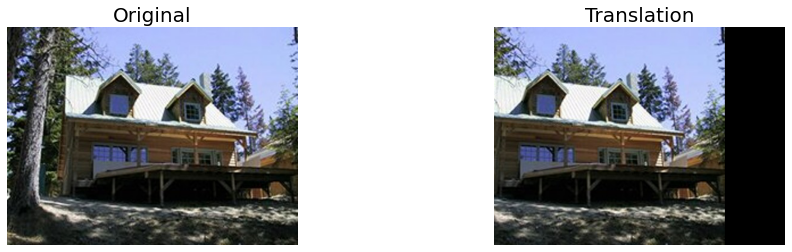

In [104]:
im = cv2.imread('./assets/tut_8_exm.jpg')
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
rows,cols,d = im.shape
h_T = np.float32([[1,0,-100],[0,1,0],[0,0,1]])
im_T = cv2.warpPerspective(im, h_T,(cols,rows))
Titles = ['Original','Translation']

plot_images([im,im_T],Titles,(1,2),figsize=(16,4),fontsize=20)


### <img src="https://img.icons8.com/external-photo3ideastudio-lineal-color-photo3ideastudio/344/external-exam-online-learning-photo3ideastudio-lineal-color-photo3ideastudio-1.png" style="height:50px;display:inline"> Answer 1.A:

* Image-2 is a 3x zoom of image 1, so the index (0,0) stay in place:
    
Scaled image has one parameter, since we scale in the same zoom for X-axis and Y-axis, means the homography will be:

$$\begin{bmatrix} 3 & 0 & 0\\ 0 & 3 & 0 \\ 0 & 0 & 1 \end{bmatrix}$$

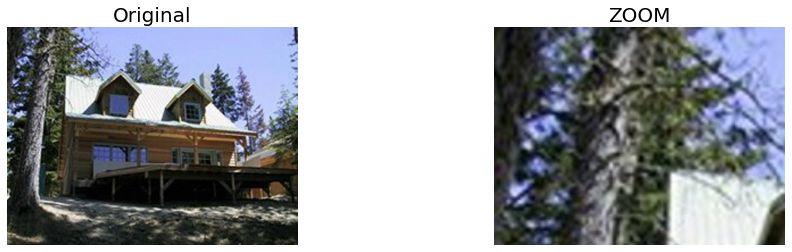

In [105]:
h_S = np.float32([[3,0,0],[0,3,0],[0,0,1]])
im_S = cv2.warpPerspective(im, h_S,(cols,rows))
Titles = ['Original','ZOOM']

plot_images([im,im_S],Titles,(1,2),figsize=(16,4),fontsize=20)


* As we said, some of the points may be a good match, and some won't.


* If we use a wrong point, we will get the wrong transformation.


* How can we solve that major problem?

* We can use our prior knowledge on the type of the trasformation, and use points that have strong evidence that are correct.


* For example, we know that homographys preserve lines, so we can try to look for keypoints that lay in a line, and use them to find the transformation.


* How would we find keypoints that lay on a line?

### <img src="https://img.icons8.com/dotty/80/000000/line.png" style="height:50px;display:inline"> RANSAC
---

The RANSAC algorithm is extremly simple, **but** it often:

* Does not produce correct model with user-defined probability
* Outputs an inaccurate model
* Does not handle degeneracies
* Can be sped up (by orders of magnitude)
* Does not gurantee minimum running time
* Needs information about scale of the noise
* Does not handle multiple models efficiently

Many improved algorithms:
* <a href="https://dspace.cvut.cz/bitstream/handle/10467/9496/2005-Matching-with-PROSAC-progressive-sample-consensus.pdf;jsessionid=AB7FDDCCABE0CA249D253E7E8F9D1DC7?sequence=1"> PROSAC</a>
    * Key idea is to assume that the similarity measure predicts correctness of a match
* <a href="http://www.bmva.org/bmvc/2002/papers/50/full_50.pdf"> Randomized RANSAC</a>  
    * Each step take a random subset of the query points and perform RANSAC
* <a href="https://ieeexplore.ieee.org/abstract/document/1541313"> KALMANSAC</a> 
* <a href="https://en.wikipedia.org/wiki/Random_sample_consensus#Development_and_improvements"> and more...</a>
* Estimating homogrpahy with RANSAC in OpenCV: ```cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)```

###  <img src="https://img.icons8.com/external-photo3ideastudio-lineal-color-photo3ideastudio/344/external-exam-online-learning-photo3ideastudio-lineal-color-photo3ideastudio-1.png" style="height:50px;display:inline"> Q1.D Ransac:

* given 200 matching points between 2 images denoted by $X_i = (x_i,y_i), i=1,...,200$
    one would like to find an ellipse.
    The form of ellipse is $A \times [x^2,xy,y^2,x,y,1]$ where $A = \begin{bmatrix} a_1\\a_2\\a_3\\ a_4 \\ a_5 \\ a_6 \\ \end{bmatrix}$
    the matching keypoints known to be noisy.
* Describe the RANSAC algorithm that fit the ellipse between the two images


### <img src="https://img.icons8.com/external-photo3ideastudio-lineal-color-photo3ideastudio/344/external-exam-online-learning-photo3ideastudio-lineal-color-photo3ideastudio-1.png" style="height:50px;display:inline"> Answer 1.D: 
* to define ellipse, we would need 5 points <a href="http://www.lee-mac.com/5pointellipse.html#:~:text=Five%20points%20are%20required%20to%20define%20a%20unique%20ellipse"> Remember why</a>, for simplicity, we can use 6 points and solve it with Least Squares just like we found the affine transform.

**step 1**: sample 6 points from $X_i$,and order them in a matrix denote by $S$:
$$ S = \begin{bmatrix} &&\dots\\ x_i^2 & x_iy_i & y_i^2 & x &y_i & 1 \\ &&\dots \end{bmatrix} $$
**step 2**: fit ellipse model with Least Squares
**step 3**: gather all points that fit the model below a choosen thrashold.
**step 4**: refine our model according to all inliers, and count them. the number of inliers will be the score of the current model.
**step 5**: repeat 1-4, untill converge.

when do we converge?

* inliers above threshold
* error threshold for the LS
* number of iterations

#### application 1: Planting images into other images

<img src="./assets/image-planting.png" width="600">

#### application 2: BirdEye

<img src="./assets/bird-eye-homography.png" width="400">

* <a href="https://csyhhu.github.io/2015/07/09/IPM/"> Image Source</a>

#### application 3: Looking into the past

<img src="./assets/look-into-past.png" width="400">

* <a href="http://blog.flickr.net/en/2010/01/27/a-look-into-the-past/ "> Image Source from Flickr</a>

#### application 4: Panorama

<img src="./assets/tut_08_pan1.png" width="600">

Obtain a wider angle view by combining multiple images

## <img src="https://img.icons8.com/doodle/96/000000/panorama.png" style="height:50px;display:inline"> Panorama
---
* [Warping](#-Warp---What-we-need-to-solve?)
* [Image Blending (Feathering)](#-Image-Blending)

<img src="./assets/tut_08_pan2.png" width="800">


<img src="./assets/tut_08_pan3.png" width="800">


<img src="./assets/tut_08_pan4.png" width="800">


### <img src="https://img.icons8.com/nolan/64/show-space-warps.png" style="height:50px;display:inline"> Warp - What we need to solve?
---

* Given source and target images, and the transformation between them, how do we align them?
* Send each pixel $x$ in image1 to its corresponding location $x’$ in image 2

<img src="./assets/tut_08_wrap1.JPG" width="600">


#### Forward Warping
---

* What if pixel lands “between” two pixels?

* Answer:  add “contribution” to several pixels and normalize (splatting)

<img src="./assets/tut_08_wrap2.JPG" width="600">


* Limitation:   Holes (some pixels are never visited)
<img src="./assets/tut_08_wrap3.JPG" width="600">


#### Inverse Warping
---
* For each pixel x’ in image 2 find its origin x in image 1

* Problem: What if pixel comes from “between” two pixels?

<img src="./assets/tut_08_wrap4.JPG" width="600">


* Answer: interpolate color value from neighbors
<img src="./assets/tut_08_wrap5.JPG" width="600">


##### Bilinear Interpolation
---
Sampling at $f(x,y)$:
<img src="./assets/tut_08_wrap6.JPG" width="300">

$$ f(x,y) = (1-a)(1-b) f[i,j]\\ + a(1-b) f[i+1,j]\\ + ab f[i+1,j+1]\\ +(1-a)b f[i,j+1]\\ $$


Python: 

* `interp2d()` - https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html
* Inverse warping in OpenCV: `cv2.warpPerspective(im,*,*,cv2.WARP_INVERSE_MAP)`


### <img src="https://img.icons8.com/external-photo3ideastudio-lineal-color-photo3ideastudio/344/external-exam-online-learning-photo3ideastudio-lineal-color-photo3ideastudio-1.png" style="height:50px;display:inline"> Q1.B
* Describe forward and backward wraping
* for the two cases before, denote if there is a diffrence between the two
* if there is, what would be better? 

reminder:
* Image-2 is a translated image 1 by 100 pixels to the left
* Image-2 is a 3x zoom of image 1, so the index (0,0) stay in place

### <img src="https://img.icons8.com/external-photo3ideastudio-lineal-color-photo3ideastudio/344/external-exam-online-learning-photo3ideastudio-lineal-color-photo3ideastudio-1.png" style="height:50px;display:inline"> Answer 1.B: 

* Read the tutorial :)

* denote reconstact indices as $\hat{X_i} = (\hat{x_i},\hat{y_i})$.

    for the first case, there is no diffrence, since eat index maped to an int index.
    
    for the second case, solving is easy and we get $\hat{X_i} = 3 X'_i $.
    
    in the forward case, $(\hat{x_1},\hat{y_1})$ for example, would be a hole, since $X'_i$ are indices, and therfore descrite numbers.
    
    the backward wraping, look at what indices created the pixels in the second image, so for the same example $\hat{X}_{(1,1)} = f(X'_{(1,1)},X'_{(1,2)},...X'_{(5,5)})$.
        
* the backward wraping, since there will be no holes

In [106]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

# original samples
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)

# interpolated samples
xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)

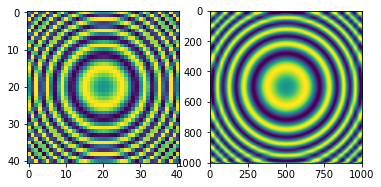

In [107]:
## Cubic
f = interpolate.interp2d(x, y, z, kind='cubic')
znew = f(xnew, ynew)

plt.figure()
plt.subplot(121)
plt.imshow(z,vmin=-1,vmax=1)
plt.subplot(122)
plt.imshow(znew,vmin=-1,vmax=1)
plt.show()

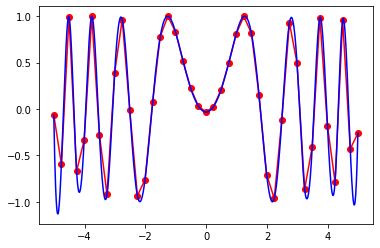

In [108]:
plt.figure()
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

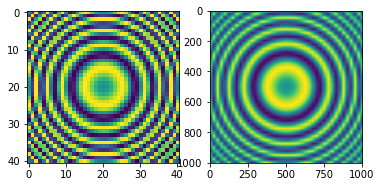

In [109]:
##linear
f2 = interpolate.interp2d(x, y, z, kind='linear')
znew2 = f2(xnew, ynew)

plt.figure()
plt.subplot(121)
plt.imshow(z,vmin=-1,vmax=1)
plt.subplot(122)
plt.imshow(znew2,vmin=-1,vmax=1)
plt.show()

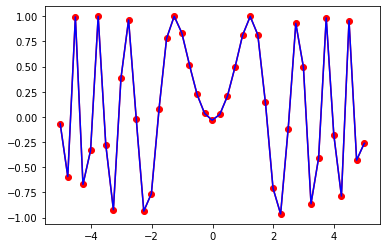

In [110]:
plt.figure()
plt.plot(x, z[0, :], 'ro-', xnew, znew2[0, :], 'b-')
plt.show()

### <img src="https://img.icons8.com/dotty/80/000000/blender.png" style="height:50px;display:inline"> Image Blending
---
<img src="./assets/tut_08_blend1.png" width="600">

* Alpha blending
* Pyramid blending

##### Alpha Blending
---

<img src="./assets/tut_08_blend3.JPG" width="600">
<img src="./assets/tut_08_blend4.JPG" width="300">

##### Pyramid Blending:
---
1. Build a Gaussian pyramid for each image
2. Build the Laplacian pyramid for each image
3. Decide/find the blending border (in the example: left half belongs to image 1, and right half to image 2 -> the blending border is `cols/2`)
   * Split by index, or
   * Split using a 2 masks (can be weighted masks)
4. Constract a new mixed pyramid - mix each level seperatly acording to (3)
5. Reconstract a blend image from the mixed pyramid

In [111]:
def create_pyrs(A,B):
    # generate Gaussian pyramid for A
    G = A.copy()
    gpA = [G]
    for i in range(6):
        G = cv2.pyrDown(G)
        gpA.append(G)
    # generate Gaussian pyramid for B
    G = B.copy()
    gpB = [G]
    for i in range(6):
        G = cv2.pyrDown(G)
        gpB.append(G)
    # generate Laplacian Pyramid for A
    lpA = [gpA[5]]
    for i in range(5,0,-1):
        GE = cv2.pyrUp(gpA[i])
        L = cv2.subtract(gpA[i-1],GE)
        lpA.append(L)
    # generate Laplacian Pyramid for B
    lpB = [gpB[5]]
    for i in range(5,0,-1):
        GE = cv2.pyrUp(gpB[i])
        L = cv2.subtract(gpB[i-1],GE)
        lpB.append(L)
    return lpA,lpB

In [112]:
def blend_images(A,B):
    lpA,lpB = create_pyrs(A,B)
    # Now add left and right halves of images in each level
    LS = []
    for la,lb in zip(lpA,lpB):
        rows,cols,dpt = la.shape
        ls = np.hstack((la[:,0:int(cols/2)], lb[:,int(cols/2):])) #mixing can also be done with a mask
        LS.append(ls)
    # now reconstruct
    ls_ = LS[0]
    for i in range(1,6):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, LS[i])
    # image with direct connecting each half
    real = np.hstack((A[:,:int(cols/2)],B[:,int(cols/2):])) 
    return real, ls_

In [113]:
def switch_texture(A,B):
    lpA,lpB = create_pyrs(A,B)
    # Now add left and right halves of images in each level
    LS = []
#     for la,lb in zip(lpA,lpB):
#         rows,cols,dpt = la.shape
#         ls = np.hstack((la[:,0:int(cols/2)], lb[:,int(cols/2):])) #mixing can also be done with a mask
#         LS.append(ls)
    # now reconstruct
    ls_ = lpA[0]
    for i in range(1,6):
        ls_ = cv2.pyrUp(ls_)
        ls_ = cv2.add(ls_, lpB[i])
    # image with direct connecting each half
    real = np.hstack((A[:,:int(cols/2)],B[:,int(cols/2):])) 
    return real, ls_

In [114]:
def alpha_blend(A,B,MASK):
    A = np.float32(A)
    B = np.float32(B)
    return np.uint8(A*MASK), np.uint8(A*MASK+B*(1-MASK))

In [115]:
A = cv2.imread('./assets/apple.jpg')
B = cv2.imread('./assets/orange.jpg')
real,ls_ = blend_images(A,B)

A_ = cv2.cvtColor(A,cv2.COLOR_BGR2RGB)
B_ = cv2.cvtColor(B,cv2.COLOR_BGR2RGB)
ls_ = cv2.cvtColor(ls_,cv2.COLOR_BGR2RGB)
real = cv2.cvtColor(real,cv2.COLOR_BGR2RGB)

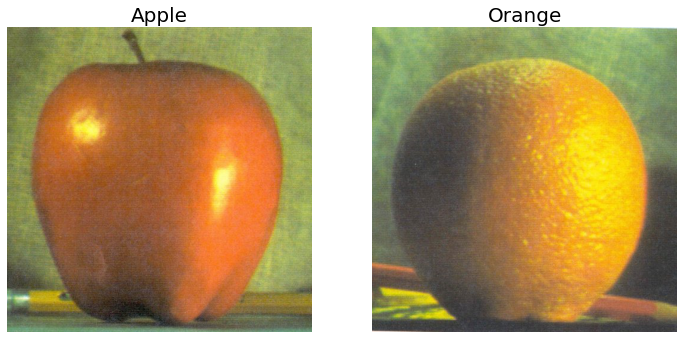

In [116]:
plot_images([A_,B_],['Apple','Orange'],(1,2),figsize=(12,12),fontsize=20)

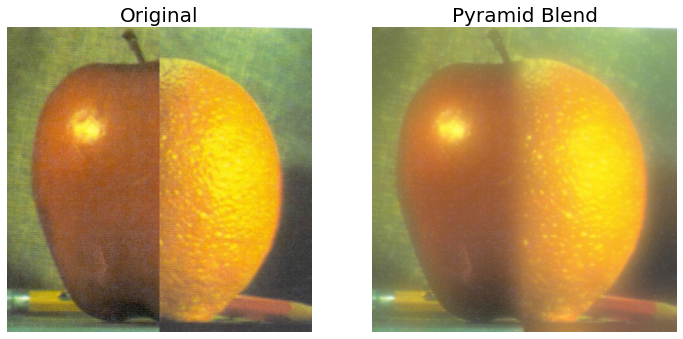

In [117]:
plot_images([real,ls_],['Original','Pyramid Blend'],(1,2),figsize=(12,12),fontsize=20)

* Alpha blending example:

In [118]:
MASK = np.ones_like(A,np.float32)
rows,cols,dpt = MASK.shape
w=20
v_dec = np.linspace(1,0,2*w)
MASK[:,int(cols/2):]=0
MASK[:,(int(cols/2)-w):(int(cols/2)+w)]=np.tile(np.reshape(v_dec,[1,-1,1]),[rows,1,3])
real,ls_ = alpha_blend(A,B,MASK)
ls_ = cv2.cvtColor(ls_,cv2.COLOR_BGR2RGB)
real = cv2.cvtColor(real,cv2.COLOR_BGR2RGB)

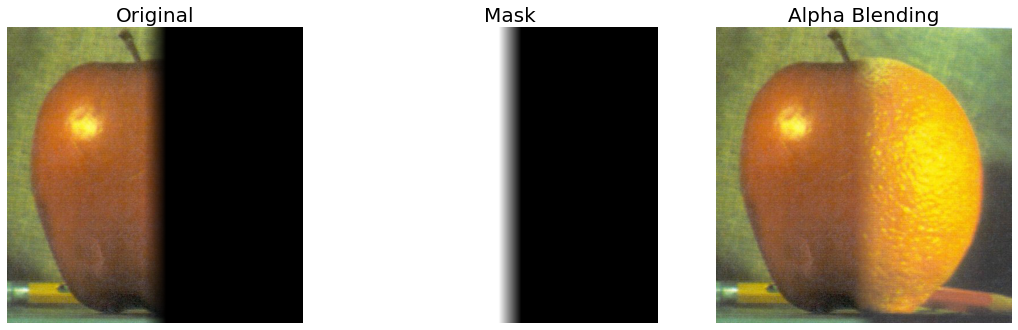

In [119]:
plot_images([real,MASK,ls_],['Original','Mask','Alpha Blending'],(1,3),figsize=(18,12),fontsize=20)

* Stylize image using pyramids:

In [120]:
real,ls_ = switch_texture(A,B)
ls_ = cv2.cvtColor(ls_,cv2.COLOR_BGR2RGB)
real = cv2.cvtColor(real,cv2.COLOR_BGR2RGB)

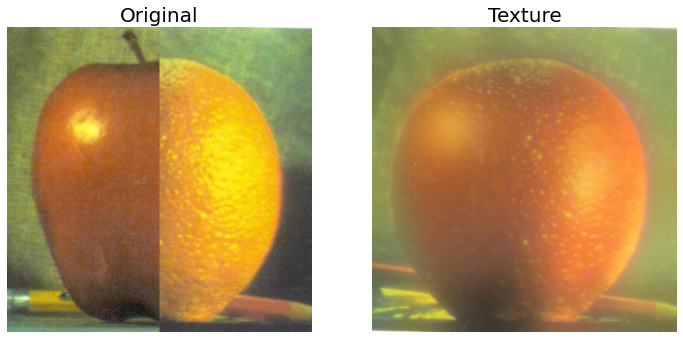

In [121]:
plot_images([real,ls_],['Original','Texture'],(1,2),figsize=(12,12),fontsize=20)

##### <img src="https://img.icons8.com/cute-clipart/64/000000/plus.png" style="height:50px;display:inline" style="height:50px;display:inline"> Blending Improvments
---

* Many algorithms have different variations of combining alpha and pyramid blending (different masks for different frequencies)
* Find the boundaries using **segmentation**

### <img src="https://img.icons8.com/ios/50/000000/summary-list.png" style="height:50px;display:inline"> Panorama - Summary
---
* Detect features
* Compute transformations between pairs of frames
* Can Refine transformations using RANSAC
* Warp all images onto a single coordinate system
* Find mixing borders (e.g. using segmentation)
* Blend


## <img src="https://img.icons8.com/cotton/50/000000/olympic-torch.png" style="height:50px;display:inline">  Transformations in Deep Learning
----
* Can we incorporate transformations in the pipeline of a deep learning algorithm?
    * Moreover, can we accelerate these transformations by performing them on a GPU?
* **YES!**

### <img src="https://img.icons8.com/bubbles/50/000000/video-playlist.png" style="height:50px;display:inline"> Recommended Videos
---
#### <img src="https://img.icons8.com/cute-clipart/64/000000/warning-shield.png" style="height:30px;display:inline"> Warning!
* These videos do not replace the lectures and tutorials.
* Please use these to get a better understanding of the material, and not as an alternative to the written material.

#### Video By Subject
* Homography
    * Image geometry and planar homography - <a href="https://www.youtube.com/watch?v=fVJeJMWZcq8">ENB339 lecture 9: Image geometry and planar homography</a>
    * Homography - <a href="https://www.youtube.com/watch?v=MlaIWymLCD8">Homography in computer vision explained</a>
* Transformations - <a href="https://www.youtube.com/watch?v=4I2S5Xhf24o">Lect. 5(1) - Linear and affine transformations</a>
* Matching Local Features
    * SIFT - <a href="https://www.youtube.com/watch?v=U0wqePj4Mx0">CSCI 512 - Lecture 12-1 SIFT</a>   


## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits


----
* EE 046746 Spring 2022 - <a href="https://www.linkedin.com/in/moshekimhi/">Moshe Kimhi</a>
* EE 046746 Spring 2020 - <a href="https://il.linkedin.com/in/dahlia-urbach-97a816123">Dahlia Urbach</a>
* Slides - Elad Osherov (Technion), Simon Lucey (CMU)
* Multiple View Geometry in Computer Vision - Hartley and Zisserman - Section 2
* <a href="cmp.felk.cvut.cz/cmp/courses/XE33PVR/WS20072008/Lectures/Supporting/constrained_lsq.pdf"> Least–squares Solution of Homogeneous Equations </a> - Center for Machine Perception - Tomas Svoboda
* <a href="http://www.computervisionmodels.com/">Computer vision: models, learning and inference</a> , Simon J.D. Prince - Section 15.1
* <a href="https://www.springer.com/gp/book/9781848829343">Computer Vision: Algorithms and Applications</a> - Richard Szeliski - Sections 2,4,6, 9 (<a href="https://piazza.com/class/k81fypit1f75kx?cid=122">Free for Technion students via remote library</a>)

* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com
